### Download & extract PACS dataset (optional)

In [1]:
# Install deps (safe to re-run)
!pip -q install datasets pillow tqdm

import os, io
from PIL import Image
from tqdm import tqdm
from datasets import load_dataset

root = "/content/data/PACS"
os.makedirs(root, exist_ok=True)

ds = load_dataset("flwrlabs/pacs", split="train")

if "category" in ds.features:
    label_field = "category"
elif "class" in ds.features:
    label_field = "class"
elif "label" in ds.features:
    label_field = "label"
else:
    raise RuntimeError(f"Unexpected schema: {ds.features}")

def class_name(row):
    v = row[label_field]
    if isinstance(v, int):
        return ds.features[label_field].names[v]
    return str(v)

# Normalize domains → art_painting/cartoon/photo/sketch
def norm_domain(v: str):
    s = str(v).strip().lower().replace(" ", "_").replace("-", "_")
    if s in {"art_painting", "cartoon", "photo", "sketch"}:
        return s
    # map common variants just in case
    if s in {"artpainting", "art_paintings"}:
        return "art_painting"
    return s  # fallback (we'll skip unknowns below)

# Write images to /content/data/PACS/<domain>/<class>/<i>.jpg
for i, row in tqdm(enumerate(ds), total=len(ds)):
    dom = norm_domain(row["domain"])
    if dom not in {"art_painting", "cartoon", "photo", "sketch"}:
        continue  # skip anything weird
    cls = class_name(row)
    out_dir = os.path.join(root, dom, cls)
    os.makedirs(out_dir, exist_ok=True)

    img = row["image"]
    if not isinstance(img, Image.Image):
        # Some datasets provide bytes; convert to PIL.Image
        img = Image.open(io.BytesIO(img["bytes"])).convert("RGB")
    img.save(os.path.join(out_dir, f"{i}.jpg"), quality=95)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9991 [00:00<?, ? examples/s]

100%|██████████| 9991/9991 [00:13<00:00, 744.31it/s]


### Imports, constants, and seed

In [2]:
import torch, random, os, numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
import numpy as np
import pandas as pd
import os

DATA_ROOT = "/content/data/PACS"
SOURCES   = ["art_painting", "cartoon", "photo"]
TARGET    = "sketch"
IMG_SIZE  = 224
BATCH_SIZE = 64
NUM_WORKERS = 2

# seed set for reproducibility
def set_seed(seed=1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1337)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
_to_rgb = transforms.Lambda(lambda im: im.convert("RGB"))

def make_loaders(data_root, img_size=224, batch_size=64, num_workers=2, sources=None, target=None):
    tfm_train = transforms.Compose([
        _to_rgb,
        transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    tfm_eval = transforms.Compose([
        _to_rgb,
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])

    def load_domain(name, tfm):
        p = Path(data_root)/name
        assert p.exists(), f"Missing domain folder: {p}"
        return datasets.ImageFolder(str(p), transform=tfm)

    # Build datasets
    src_train, per_domain_eval = [], {}
    class_to_idx = None

    for d in sources:
        ds_tr = load_domain(d, tfm_train)
        ds_ev = load_domain(d, tfm_eval)
        if class_to_idx is None:
            class_to_idx = ds_tr.class_to_idx
        else:
            assert ds_tr.class_to_idx == class_to_idx, "Class mapping differs across domains."
        assert ds_ev.class_to_idx == class_to_idx
        src_train.append(ds_tr)
        per_domain_eval[d] = ds_ev

    target_eval = load_domain(target, tfm_eval)
    assert target_eval.class_to_idx == class_to_idx
    per_domain_eval[target] = target_eval

    # Loaders
    train_ds = ConcatDataset(src_train)
    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True,
        persistent_workers=(num_workers > 0), drop_last=True
    )
    eval_loaders = {
        d: DataLoader(ds, batch_size=batch_size, shuffle=False,
                      num_workers=num_workers, pin_memory=True,
                      persistent_workers=(num_workers > 0))
        for d, ds in per_domain_eval.items()
    }

    num_classes = len(target_eval.classes)
    return train_loader, eval_loaders, num_classes, target_eval.classes

train_loader, eval_loaders, num_classes, classes = make_loaders(
    DATA_ROOT, IMG_SIZE, BATCH_SIZE, NUM_WORKERS, SOURCES, TARGET
)
print(f"Train size: {len(train_loader.dataset)} | Num classes: {num_classes}")
print("Domains loaded:", list(eval_loaders.keys()))
print("Classes:", classes)

Train size: 6062 | Num classes: 7
Domains loaded: ['art_painting', 'cartoon', 'photo', 'sketch']
Classes: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']


In [4]:
def build_resnet50(num_classes: int):
    # pretrained ResNet-50, replace final layer
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

@torch.no_grad()
def evaluate(model, loaders, device):
    model.eval()
    acc = {}
    for dname, loader in loaders.items():
        correct, total = 0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total   += y.numel()
        acc[dname] = correct / max(total, 1)
    return acc


def train_erm(
    sources,
    target,
    train_loader,
    eval_loaders,
    num_classes,
    epochs=20,
    lr=3e-4,
    wd=0.05,
    out_dir="outputs_erm",
    seed=1337,
    use_amp=True,
):
    np.random.seed(seed); torch.manual_seed(seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = build_resnet50(num_classes).to(device)

    opt   = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    loss_fn = nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.type=="cuda"))

    best_target = 0.0
    logs = []
    os.makedirs(out_dir, exist_ok=True)

    for ep in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        seen = 0

        pbar = tqdm(train_loader, desc=f"Epoch {ep}/{epochs}", leave=False)
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=(use_amp and device.type=="cuda")):
                logits = model(x)
                loss = loss_fn(logits, y)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            running_loss += loss.item() * y.size(0)
            seen += y.size(0)

        sched.step()

        acc = evaluate(model, eval_loaders, device)
        src_accs = [acc[d] for d in sources]
        avg_src = float(np.mean(src_accs))
        worst_src = float(min(src_accs))

        # Log
        row = {
            "epoch": ep,
            "train_loss": running_loss / max(seen, 1),
            "target_acc": acc[target],
            "avg_source_acc": avg_src,
            "worst_source_acc": worst_src,
        }
        for d in sources + [target]:
            row[f"acc_{d}"] = acc[d]
        logs.append(row)

        print(f"[Ep {ep:02d}] loss={row['train_loss']:.4f} | "
              f"tgt({target})={acc[target]:.3f} | src_avg={avg_src:.3f} | worst_src={worst_src:.3f}")

        # Save best-by-target
        if acc[target] > best_target:
            best_target = acc[target]
            torch.save(model.state_dict(), os.path.join(out_dir, "best_model.pt"))

    df = pd.DataFrame(logs)
    df.to_csv(os.path.join(out_dir, "training_log.csv"), index=False)
    print(f"\nBest target ({target}) accuracy: {best_target:.3f}")
    return df


In [ ]:
# Uses the loaders you already created:
# train_loader, eval_loaders, num_classes, classes = make_loaders(...)

df_logs = train_erm(
    sources=SOURCES,
    target=TARGET,
    train_loader=train_loader,
    eval_loaders=eval_loaders,
    num_classes=num_classes,
    epochs=20,
    lr=3e-4,
    wd=0.05,
    out_dir="outputs_erm",
    seed=1337,
    use_amp=True,   # set False if you hit AMP issues
)

# Peek last few rows
df_logs.tail()


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s]
/tmp/ipython-input-2102803089.py:44: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.type=="cuda"))
Epoch 1/20:   0%|          | 0/94 [00:00<?, ?it/s]/tmp/ipython-input-2102803089.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and device.type=="cuda")):


[Ep 01] loss=0.4052 | tgt(sketch)=0.711 | src_avg=0.967 | worst_src=0.958


[Ep 02] loss=0.1278 | tgt(sketch)=0.582 | src_avg=0.976 | worst_src=0.965


[Ep 03] loss=0.0820 | tgt(sketch)=0.663 | src_avg=0.985 | worst_src=0.980


[Ep 04] loss=0.0750 | tgt(sketch)=0.601 | src_avg=0.990 | worst_src=0.985


[Ep 05] loss=0.0539 | tgt(sketch)=0.549 | src_avg=0.984 | worst_src=0.967


[Ep 06] loss=0.0448 | tgt(sketch)=0.701 | src_avg=0.996 | worst_src=0.992


[Ep 07] loss=0.0387 | tgt(sketch)=0.734 | src_avg=0.995 | worst_src=0.987


[Ep 08] loss=0.0231 | tgt(sketch)=0.644 | src_avg=0.994 | worst_src=0.991


[Ep 09] loss=0.0165 | tgt(sketch)=0.697 | src_avg=0.998 | worst_src=0.998


[Ep 10] loss=0.0224 | tgt(sketch)=0.694 | src_avg=0.997 | worst_src=0.996


[Ep 11] loss=0.0146 | tgt(sketch)=0.724 | src_avg=1.000 | worst_src=0.999


[Ep 12] loss=0.0089 | tgt(sketch)=0.707 | src_avg=0.999 | worst_src=0.998


[Ep 13] loss=0.0076 | tgt(sketch)=0.729 | src_avg=1.000 | worst_src=1.000


[Ep 14] loss=0.0064 | tgt(sketch)=0.700 | src_avg=1.000 | worst_src=1.000


[Ep 15] loss=0.0026 | tgt(sketch)=0.689 | src_avg=1.000 | worst_src=1.000


[Ep 16] loss=0.0032 | tgt(sketch)=0.729 | src_avg=1.000 | worst_src=1.000


[Ep 17] loss=0.0044 | tgt(sketch)=0.728 | src_avg=1.000 | worst_src=1.000


[Ep 18] loss=0.0039 | tgt(sketch)=0.736 | src_avg=1.000 | worst_src=1.000


[Ep 19] loss=0.0029 | tgt(sketch)=0.728 | src_avg=1.000 | worst_src=1.000


[Ep 20] loss=0.0041 | tgt(sketch)=0.729 | src_avg=1.000 | worst_src=1.000

Best target (sketch) accuracy: 0.736


,epoch,train_loss,target_acc,avg_source_acc,worst_source_acc,acc_art_painting,acc_cartoon,acc_photo,acc_sketch
15,16,0.003183,0.729448,1.0,1.0,1.0,1.0,1.0,0.729448
16,17,0.004430,0.728430,1.0,1.0,1.0,1.0,1.0,0.728430
17,18,0.003913,0.735811,1.0,1.0,1.0,1.0,1.0,0.735811
18,19,0.002883,0.728175,1.0,1.0,1.0,1.0,1.0,0.728175
19,20,0.004060,0.729193,1.0,1.0,1.0,1.0,1.0,0.729193


In [ ]:
import pandas as pd

log_path = "outputs_erm/training_log.csv"
df = pd.read_csv(log_path)

best_idx = df["target_acc"].idxmax()
best = df.iloc[best_idx]

summary = {
    "best_epoch": int(best["epoch"]),
    "target_sketch_acc": round(float(best["target_acc"]), 4),
    "avg_source_acc": round(float(best["avg_source_acc"]), 4),
    "worst_source_acc": round(float(best["worst_source_acc"]), 4),
}
for d in SOURCES + [TARGET]:
    summary[f"{d}_acc"] = round(float(best[f"acc_{d}"]), 4)

summary


{'best_epoch': 18,
 'target_sketch_acc': 0.7358,
 'avg_source_acc': 1.0,
 'worst_source_acc': 1.0,
 'art_painting_acc': 1.0,
 'cartoon_acc': 1.0,
 'photo_acc': 1.0,
 'sketch_acc': 0.7358}

# IRMv1

In [ ]:

_to_rgb = transforms.Lambda(lambda im: im.convert("RGB"))

def make_per_domain_train_loaders(data_root, img_size=224, batch_size=12, num_workers=2, sources=None):
    # same train transform as before
    tfm_train = transforms.Compose([
        _to_rgb,
        transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.1,0.1,0.1,0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    loaders = {}
    class_to_idx = None
    for d in sources:
        ds = datasets.ImageFolder(str(Path(data_root)/d), transform=tfm_train)
        if class_to_idx is None:
          class_to_idx = ds.class_to_idx
        else:
          assert ds.class_to_idx == class_to_idx
        loaders[d] = DataLoader(ds, batch_size=batch_size, shuffle=True,
                                num_workers=num_workers, pin_memory=True,
                                persistent_workers=(num_workers>0), drop_last=True)
    return loaders


In [ ]:
import torch, numpy as np, os, random, itertools
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
import pandas as pd
from torch.optim.swa_utils import AveragedModel, SWALR

def build_resnet50(num_classes: int):
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    # freeze all, then unfreeze layer4+layer3 first; we’ll unfreeze layer2 later
    for p in m.parameters(): p.requires_grad = False
    for p in m.layer4.parameters(): p.requires_grad = True
    for p in m.layer3.parameters(): p.requires_grad = True
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def set_bn_eval(m):
    if isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
        m.eval()

def irm_penalty(loss, dummy_w):
    g = torch.autograd.grad(loss, [dummy_w], create_graph=True)[0]
    return torch.sum(g**2)

def train_irm(
    sources, target, per_domain_train_loaders, eval_loaders, num_classes,
    epochs, lr=3e-4, wd=0.0, out_dir="outputs_irm",
    seed=1337, use_amp=True,
    lambda_warmup_epochs = 3,    # long warmup
    lambda_after=10.0,
    grad_accum_steps=2,
    domains_per_step=2,        # 2 domains per step for stable penalty
    unfreeze_layer2_at=10,     # give more capacity mid-training
    use_swa=True, swa_start=20 # SWA last few epochs
):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = build_resnet50(num_classes).to(device)
    model = model.to(memory_format=torch.channels_last)
    model.apply(set_bn_eval)  # freeze BN stats

    opt   = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=1e-6)
    ce    = nn.CrossEntropyLoss()
    scaler = torch.amp.GradScaler('cuda', enabled=(use_amp and device.type=='cuda'))
    torch.set_float32_matmul_precision('medium')

    # SWA wrapper (activates after swa_start)
    swa_model = AveragedModel(model) if use_swa else None
    swa_sched = SWALR(opt, swa_lr=lr*0.5) if use_swa else None  # lr will be overridden after swa_start

    # Iterators
    domain_iters = {d: iter(per_domain_train_loaders[d]) for d in sources}
    domains = list(sources)

    best_target = 0.0
    logs = []
    os.makedirs(out_dir, exist_ok=True)

    for ep in range(1, epochs+1):
        # λ schedule
        if ep <= lambda_warmup_epochs:
            lam = 1.0
        else:
            lam = lambda_after
        if ep == 6:  # e.g., when changing lam
            for g in opt.param_groups:
                g['lr'] *= 0.3

        # (If you have SWA wired)
        if use_swa and ep >= swa_start:
            swa_model.update_parameters(model)
            swa_sched.step()
        else:
            sched.step()

        # unfreeze layer2 later for extra capacity
        if ep == unfreeze_layer2_at:
            for p in model.layer2.parameters(): p.requires_grad = True

        model.train()
        steps = min(len(ld) for ld in per_domain_train_loaders.values())
        running_loss = 0.0
        running_pen  = 0.0
        seen = 0

        opt.zero_grad(set_to_none=True)
        for step in tqdm(range(steps), desc=f"[IRM+] Epoch {ep}/{epochs}", leave=False):
            # pick K distinct domains this step
            chosen = [domains[(step + k) % len(domains)] for k in range(domains_per_step)]
            losses, penalties, batch_sizes = [], [], []

            for d in chosen:
                try:
                    x, y = next(domain_iters[d])
                except StopIteration:
                    domain_iters[d] = iter(per_domain_train_loaders[d])
                    x, y = next(domain_iters[d])

                x = x.to(device, memory_format=torch.channels_last, non_blocking=True)
                y = y.to(device, non_blocking=True)
                w = torch.tensor(1.0, requires_grad=True, device=device)

                with torch.amp.autocast('cuda', enabled=(use_amp and device.type=="cuda")):
                    logits = model(x) * w
                    loss_d = ce(logits, y)
                pen_d = irm_penalty(loss_d, w)

                losses.append(loss_d)
                penalties.append(pen_d)
                batch_sizes.append(y.size(0))

            loss = torch.stack(losses).mean()
            penalty = torch.stack(penalties).mean()
            total = loss + lam * penalty

            scaler.scale(total / grad_accum_steps).backward()
            running_loss += total.item() * sum(batch_sizes)
            running_pen  += penalty.item() * sum(batch_sizes)
            seen += sum(batch_sizes)

            if (step + 1) % grad_accum_steps == 0:
                torch.nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, model.parameters()), 1.0)
                scaler.step(opt)
                scaler.update()
                opt.zero_grad(set_to_none=True)

        # LR schedule or SWA phase
        if use_swa and ep >= swa_start:
            swa_model.update_parameters(model)
            swa_sched.step()
        else:
            sched.step()

        # eval helper
        @torch.no_grad()
        def evaluate(m, loaders):
            m.eval(); out={}
            for name, ld in loaders.items():
                c=t=0
                for xb,yb in ld:
                    xb = xb.to(device, memory_format=torch.channels_last)
                    yb = yb.to(device)
                    p = m(xb).argmax(1)
                    c += (p==yb).sum().item(); t += yb.numel()
                out[name]=c/max(t,1)
            return out

        # If SWA just started or at the end, update BN for SWA model (needs BN stats)
        if use_swa and ep == epochs:
            # temporarily un-freeze BN for update_bn
            def set_bn_train(m):
                if isinstance(m, torch.nn.modules.batchnorm._BatchNorm): m.train()
            swa_model.apply(set_bn_train)
            torch.optim.swa_utils.update_bn(next(iter(eval_loaders.values())), swa_model, device=device)
            acc = evaluate(swa_model, eval_loaders)
        else:
            acc = evaluate(model, eval_loaders)

        src_accs = [acc[d] for d in sources]
        avg_src, worst_src = float(np.mean(src_accs)), float(min(src_accs))
        row = {
            "epoch": ep,
            "lambda": lam,
            "train_loss": running_loss / max(seen,1),
            "irm_penalty": running_pen / max(seen,1),
            "target_acc": acc[target],
            "avg_source_acc": avg_src,
            "worst_source_acc": worst_src,
        }
        for d in sources+[target]:
            row[f"acc_{d}"] = acc[d]
        logs.append(row)

        print(f"[IRM+ Ep {ep:02d}] tgt={acc[target]:.3f} | src_avg={avg_src:.3f} | worst_src={worst_src:.3f} | "
              f"λ={lam:.2f} | pen={row['irm_penalty']:.4f}")

        if acc[target] > best_target:
            best_target = acc[target]
            torch.save((swa_model if (use_swa and ep>=swa_start) else model).state_dict(),
                       os.path.join(out_dir, "best_model.pt"))

    df = pd.DataFrame(logs)
    os.makedirs(out_dir, exist_ok=True)
    df.to_csv(os.path.join(out_dir, "training_log.csv"), index=False)
    print(f"\n✅ IRM+ best target ({target}) acc: {best_target:.3f}")
    return df


In [ ]:

per_domain_train = make_per_domain_train_loaders(
    data_root=DATA_ROOT,
    sources=SOURCES,
)

df_irm = train_irm(
    sources=SOURCES,
    target=TARGET,
    per_domain_train_loaders=per_domain_train,
    eval_loaders=eval_loaders,
    num_classes=num_classes,
    epochs=20,
    lr=3e-4,
    wd=0.0,
    out_dir="outputs_irm",
    lambda_warmup_epochs=3,
    lambda_after=10.0,
    grad_accum_steps=2,
    domains_per_step=2,
    unfreeze_layer2_at=6,
    use_swa=True, swa_start=12,
)
best_idx = df_irm["target_acc"].idxmax()
best = df_irm.iloc[best_idx]
{
    "best_epoch": int(best["epoch"]),
    "target_sketch_acc": round(float(best["target_acc"]), 4),
    "avg_source_acc": round(float(best["avg_source_acc"]), 4),
    "worst_source_acc": round(float(best["worst_source_acc"]), 4),
    "lambda_used": float(best["lambda"]),
    "irm_penalty_at_best": round(float(best["irm_penalty"]), 6),
    **{f"{d}_acc": round(float(best[f"acc_{d}"]), 4) for d in SOURCES+[TARGET]}
}

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 220MB/s]
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


[IRM+ Ep 01] tgt=0.583 | src_avg=0.894 | worst_src=0.793 | λ=1.00 | pen=0.0726


[IRM+ Ep 02] tgt=0.689 | src_avg=0.954 | worst_src=0.927 | λ=1.00 | pen=0.0386


[IRM+ Ep 03] tgt=0.710 | src_avg=0.945 | worst_src=0.900 | λ=1.00 | pen=0.0274


[IRM+ Ep 04] tgt=0.550 | src_avg=0.823 | worst_src=0.761 | λ=10.00 | pen=0.0745


[IRM+ Ep 05] tgt=0.603 | src_avg=0.876 | worst_src=0.819 | λ=10.00 | pen=0.0449


[IRM+ Ep 06] tgt=0.651 | src_avg=0.907 | worst_src=0.873 | λ=10.00 | pen=0.0363


[IRM+ Ep 07] tgt=0.657 | src_avg=0.935 | worst_src=0.909 | λ=10.00 | pen=0.0322


[IRM+ Ep 08] tgt=0.684 | src_avg=0.929 | worst_src=0.898 | λ=10.00 | pen=0.0302


[IRM+ Ep 09] tgt=0.666 | src_avg=0.938 | worst_src=0.910 | λ=10.00 | pen=0.0282


[IRM+ Ep 10] tgt=0.697 | src_avg=0.937 | worst_src=0.911 | λ=10.00 | pen=0.0223


[IRM+ Ep 11] tgt=0.673 | src_avg=0.937 | worst_src=0.907 | λ=10.00 | pen=0.0182


[IRM+ Ep 12] tgt=0.656 | src_avg=0.941 | worst_src=0.913 | λ=10.00 | pen=0.0220


[IRM+ Ep 13] tgt=0.698 | src_avg=0.949 | worst_src=0.926 | λ=10.00 | pen=0.0232


[IRM+ Ep 14] tgt=0.686 | src_avg=0.959 | worst_src=0.939 | λ=10.00 | pen=0.0155


[IRM+ Ep 15] tgt=0.735 | src_avg=0.967 | worst_src=0.953 | λ=10.00 | pen=0.0247


[IRM+ Ep 16] tgt=0.775 | src_avg=0.968 | worst_src=0.955 | λ=10.00 | pen=0.0229


[IRM+ Ep 17] tgt=0.736 | src_avg=0.973 | worst_src=0.959 | λ=10.00 | pen=0.0195


[IRM+ Ep 18] tgt=0.757 | src_avg=0.962 | worst_src=0.942 | λ=10.00 | pen=0.0222


[IRM+ Ep 19] tgt=0.640 | src_avg=0.986 | worst_src=0.981 | λ=10.00 | pen=0.0229


[IRM+ Ep 20] tgt=0.682 | src_avg=0.976 | worst_src=0.948 | λ=10.00 | pen=0.0116

✅ IRM+ best target (sketch) acc: 0.775


{'best_epoch': 16,
 'target_sketch_acc': 0.7753,
 'avg_source_acc': 0.968,
 'worst_source_acc': 0.9548,
 'lambda_used': 10.0,
 'irm_penalty_at_best': 0.022888,
 'art_painting_acc': 0.9551,
 'cartoon_acc': 0.9548,
 'photo_acc': 0.994,
 'sketch_acc': 0.7753}

# Group-DRO

In [ ]:
class RoundRobinIterator:
    def __init__(self, loaders_dict):
        self.domains = list(loaders_dict.keys())
        self.loaders = loaders_dict
        self.iters = {d: iter(loaders_dict[d]) for d in self.domains}
        self.ptr = 0
    def next_batch(self):
        d = self.domains[self.ptr]
        self.ptr = (self.ptr + 1) % len(self.domains)
        try:
            x,y = next(self.iters[d])
        except StopIteration:
            self.iters[d] = iter(self.loaders[d])
            x,y = next(self.iters[d])
        return d, x, y

@torch.no_grad()
def evaluate(model, loaders, device):
    model.eval()
    out = {}
    for name, ld in loaders.items():
        c = t = 0
        for xb, yb in ld:
            xb = xb.to(device, memory_format=torch.channels_last)
            yb = yb.to(device)
            p = model(xb).argmax(1)
            c += (p == yb).sum().item()
            t += yb.numel()
        out[name] = c / max(t, 1)
    return out

def train_groupdro(
    sources, target, per_domain_train_loaders, eval_loaders, num_classes,
    epochs=20, lr=3e-4, wd=0.0, eta=0.03,   # eta = EG step for domain weights
    out_dir="outputs_groupdro", seed=1337, use_amp=True
):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = build_resnet50(num_classes).to(device)
    model = model.to(memory_format=torch.channels_last)
    model.apply(set_bn_eval)

    opt   = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=1e-6)
    ce    = nn.CrossEntropyLoss()
    scaler = torch.amp.GradScaler('cuda', enabled=(use_amp and device.type=='cuda'))
    torch.set_float32_matmul_precision('medium')

    # Domain weights q (on simplex), initialized uniform
    q = torch.ones(len(sources), device=device) / len(sources)
    dom2idx = {d:i for i,d in enumerate(sources)}
    iterator = RoundRobinIterator(per_domain_train_loaders)

    best_tgt = 0.0
    logs = []
    os.makedirs(out_dir, exist_ok=True)

    steps_per_epoch = min(len(ld) for ld in per_domain_train_loaders.values())

    for ep in range(1, epochs+1):
        model.train()
        for _ in tqdm(range(steps_per_epoch), desc=f"[GroupDRO] Epoch {ep}/{epochs}", leave=False):
            d, x, y = iterator.next_batch()
            x = x.to(device, memory_format=torch.channels_last, non_blocking=True)
            y = y.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', enabled=(use_amp and device.type=='cuda')):
                logits = model(x)
                loss_d = ce(logits, y)
                loss = q[dom2idx[d]] * loss_d     # weighted current-domain loss

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, model.parameters()), 1.0)
            scaler.step(opt); scaler.update()

            # Exponentiated-gradient update on q (adversarial reweighting)
            with torch.no_grad():
                # increase weight on domains with higher loss
                grad_q = torch.zeros_like(q)
                grad_q[dom2idx[d]] = loss_d.detach()
                q *= torch.exp(eta * grad_q)
                q /= q.sum()  # project back to simplex

        sched.step()

        # Eval
        acc = evaluate(model, eval_loaders, device)
        src = [acc[d] for d in sources]
        row = {
            "epoch": ep,
            "target_acc": acc[target],
            "avg_source_acc": float(np.mean(src)),
            "worst_source_acc": float(min(src)),
            "q": q.detach().float().cpu().numpy().tolist(),
            **{f"acc_{d}": acc[d] for d in sources+[target]}
        }
        logs.append(row)
        print(f"[GroupDRO Ep {ep:02d}] tgt={acc[target]:.3f} | src_avg={row['avg_source_acc']:.3f} "
              f"| worst_src={row['worst_source_acc']:.3f} | q={np.round(row['q'],3)}")

        if acc[target] > best_tgt:
            best_tgt = acc[target]
            torch.save(model.state_dict(), os.path.join(out_dir, "best_model.pt"))

    df = pd.DataFrame(logs)
    df.to_csv(os.path.join(out_dir, "training_log.csv"), index=False)
    print(f"\n✅ GroupDRO best target ({target}) acc: {best_tgt:.3f}")
    return df

In [ ]:

per_domain_train = make_per_domain_train_loaders(
    data_root=DATA_ROOT,
    sources=SOURCES,
)

df_gdro = train_groupdro(
    sources=SOURCES,
    target=TARGET,
    per_domain_train_loaders=per_domain_train,
    eval_loaders=eval_loaders,
    num_classes=num_classes,
    epochs=20,        # you can try 20 if it’s stable
    lr=3e-4,
    wd=0.0,
    eta=0.03,         # if unstable, try 0.02; if too slow, 0.1
    out_dir="outputs_groupdro",
    seed=1337,
    use_amp=True
)

best_idx = df_gdro["target_acc"].idxmax()
best = df_gdro.iloc[best_idx]
summary_gdro = {
    "best_epoch": int(best["epoch"]),
    "target_sketch_acc": round(float(best["target_acc"]), 4),
    "avg_source_acc": round(float(best["avg_source_acc"]), 4),
    "worst_source_acc": round(float(best["worst_source_acc"]), 4),
    **{f"{d}_acc": round(float(best[f'acc_{d}']), 4) for d in SOURCES+[TARGET]},
    "q_at_best": [round(v, 4) for v in best["q"]],
}
summary_gdro


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


[GroupDRO Ep 01] tgt=0.432 | src_avg=0.865 | worst_src=0.717 | q=[0.379 0.387 0.234]


[GroupDRO Ep 02] tgt=0.609 | src_avg=0.930 | worst_src=0.884 | q=[0.397 0.434 0.169]


[GroupDRO Ep 03] tgt=0.616 | src_avg=0.947 | worst_src=0.895 | q=[0.392 0.488 0.12 ]


[GroupDRO Ep 04] tgt=0.675 | src_avg=0.951 | worst_src=0.924 | q=[0.389 0.523 0.088]


[GroupDRO Ep 05] tgt=0.685 | src_avg=0.967 | worst_src=0.950 | q=[0.392 0.537 0.071]


[GroupDRO Ep 06] tgt=0.765 | src_avg=0.963 | worst_src=0.926 | q=[0.396 0.546 0.058]


[GroupDRO Ep 07] tgt=0.739 | src_avg=0.966 | worst_src=0.929 | q=[0.405 0.553 0.041]


[GroupDRO Ep 08] tgt=0.755 | src_avg=0.968 | worst_src=0.938 | q=[0.381 0.585 0.033]


[GroupDRO Ep 09] tgt=0.755 | src_avg=0.967 | worst_src=0.945 | q=[0.367 0.607 0.026]


[GroupDRO Ep 10] tgt=0.730 | src_avg=0.960 | worst_src=0.940 | q=[0.366 0.614 0.02 ]


[GroupDRO Ep 11] tgt=0.703 | src_avg=0.984 | worst_src=0.972 | q=[0.383 0.603 0.015]


[GroupDRO Ep 12] tgt=0.776 | src_avg=0.981 | worst_src=0.970 | q=[0.372 0.615 0.013]


[GroupDRO Ep 13] tgt=0.786 | src_avg=0.978 | worst_src=0.958 | q=[0.395 0.594 0.011]


[GroupDRO Ep 14] tgt=0.782 | src_avg=0.983 | worst_src=0.972 | q=[0.419 0.572 0.008]


[GroupDRO Ep 15] tgt=0.784 | src_avg=0.983 | worst_src=0.970 | q=[0.432 0.562 0.006]


[GroupDRO Ep 16] tgt=0.795 | src_avg=0.989 | worst_src=0.975 | q=[0.403 0.591 0.005]


[GroupDRO Ep 17] tgt=0.802 | src_avg=0.989 | worst_src=0.975 | q=[0.407 0.588 0.005]


[GroupDRO Ep 18] tgt=0.793 | src_avg=0.988 | worst_src=0.975 | q=[0.379 0.617 0.004]


[GroupDRO Ep 19] tgt=0.786 | src_avg=0.982 | worst_src=0.964 | q=[0.362 0.635 0.004]


[GroupDRO Ep 20] tgt=0.798 | src_avg=0.993 | worst_src=0.985 | q=[0.333 0.664 0.003]

✅ GroupDRO best target (sketch) acc: 0.802


{'best_epoch': 17,
 'target_sketch_acc': 0.8017,
 'avg_source_acc': 0.9888,
 'worst_source_acc': 0.9748,
 'art_painting_acc': 0.9922,
 'cartoon_acc': 0.9748,
 'photo_acc': 0.9994,
 'sketch_acc': 0.8017,
 'q_at_best': [0.4071, 0.5882, 0.0046]}

# SAM

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Optimizer

class SAM(Optimizer):
    """Sharpness-Aware Minimization (SAM) wrapper.
       Works with SGD/Adam/AdamW. Call first_step(...), then second_step(...).
    """
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho > 0.0
        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super().__init__(params, defaults)
        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups  # keep ref

    @torch.no_grad()
    def _grad_norm(self):
        device = self.param_groups[0]["params"][0].device
        norms = []
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad
                if group.get("adaptive", False):
                    grad = grad * (p.abs() + 1e-12)
                norms.append(torch.norm(grad, p=2))
        if not norms:
            return torch.tensor(0.0, device=device)
        return torch.norm(torch.stack(norms), p=2)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        rho = self.param_groups[0]["rho"]
        adaptive = self.param_groups[0].get("adaptive", False)
        grad_norm = self._grad_norm()
        scale = rho / (grad_norm + 1e-12)

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = p.grad
                if adaptive:
                    e_w = e_w * (p.abs() + 1e-12)
                p.add_(e_w, alpha=scale)

        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if "old_p" not in self.state[p]:
                    continue
                p.data.copy_(self.state[p]["old_p"])
        self.base_optimizer.step()
        if zero_grad:
            self.zero_grad()

    def step(self):
        # not used; call first_step/second_step explicitly
        raise NotImplementedError

    def zero_grad(self, *args, **kwargs):
        self.base_optimizer.zero_grad(*args, **kwargs)

    def state_dict(self):
        return {
            "base": self.base_optimizer.state_dict(),
            "sam": super().state_dict(),
        }

    def load_state_dict(self, state_dict):
        self.base_optimizer.load_state_dict(state_dict["base"])
        super().load_state_dict(state_dict["sam"])


In [ ]:
import torch, numpy as np, os
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
import pandas as pd
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

def build_resnet50_sam(num_classes: int, train_layers=("layer3","layer4","fc")):
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    for p in m.parameters(): p.requires_grad = False
    if "layer3" in train_layers:
        for p in m.layer3.parameters(): p.requires_grad = True
    if "layer4" in train_layers:
        for p in m.layer4.parameters(): p.requires_grad = True
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

@torch.no_grad()
def evaluate(model, loaders, device):
    model.eval()
    acc = {}
    for name, ld in loaders.items():
        c=t=0
        for xb, yb in ld:
            xb = xb.to(device, memory_format=torch.channels_last)
            yb = yb.to(device)
            pred = model(xb).argmax(1)
            c += (pred==yb).sum().item(); t += yb.numel()
        acc[name] = c / max(t,1)
    return acc

def set_bn_eval(m):
    # Freeze BN running stats (affine params still train). Helps SAM stability.
    if isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
        m.eval()

def train_erm_sam(
    train_loader, eval_loaders, num_classes,
    epochs=20, base_lr=3e-4, wd=1e-4, rho=0.075, use_sgd=False,
    out_dir="outputs_sam_asam", seed=1337, use_amp=True,
    swa_start_epoch=14
):
    np.random.seed(seed); torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- model ---
    model = build_resnet50_sam(num_classes).to(device)
    model = model.to(memory_format=torch.channels_last)
    model.apply(set_bn_eval)  # freeze BN running stats for both passes

    # --- optimizer: ASAM (adaptive=True) ---
    if use_sgd:
        base_opt = optim.SGD
        opt = SAM(
            model.parameters(), base_optimizer=base_opt,
            rho=rho, adaptive=True, lr=base_lr, momentum=0.9,
            weight_decay=wd, nesterov=True
        )
    else:
        base_opt = optim.AdamW
        opt = SAM(
            model.parameters(), base_optimizer=base_opt,
            rho=rho, adaptive=True, lr=base_lr, weight_decay=wd
        )

    # --- LR schedule: warmup + cosine ---
    warmup_epochs = 3
    warm = torch.optim.lr_scheduler.LinearLR(opt.base_optimizer, start_factor=0.2, total_iters=warmup_epochs)
    cos  = torch.optim.lr_scheduler.CosineAnnealingLR(opt.base_optimizer, T_max=epochs - warmup_epochs, eta_min=1e-6)
    sched = torch.optim.lr_scheduler.SequentialLR(opt.base_optimizer, [warm, cos], milestones=[warmup_epochs])

    # --- SWA (average last few epochs) ---
    use_swa = True
    swa_model = AveragedModel(model) if use_swa else None
    swa_sched = SWALR(opt.base_optimizer, swa_lr=base_lr*0.5) if use_swa else None

    # --- loss, AMP, misc ---
    ce = nn.CrossEntropyLoss(label_smoothing=0.1)
    scaler = torch.amp.GradScaler('cuda', enabled=(use_amp and device.type=='cuda'))
    torch.set_float32_matmul_precision('medium')

    best_tgt = 0.0
    logs = []
    os.makedirs(out_dir, exist_ok=True)

    for ep in range(1, epochs+1):
        model.train()
        running_loss = 0.0; seen = 0

        # (optional) unfreeze a bit more capacity after warmup
        if ep == warmup_epochs + 1:
            if hasattr(model, "layer2"):
                for p in model.layer2.parameters(): p.requires_grad = True

        for xb, yb in tqdm(train_loader, desc=f"[SAM/ASAM] Epoch {ep}/{epochs}", leave=False):
            xb = xb.to(device, memory_format=torch.channels_last, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            # ---- pass 1: ascent (compute epsilon) ----
            opt.zero_grad()
            with torch.amp.autocast('cuda', enabled=(use_amp and device.type=='cuda')):
                logits = model(xb)
                loss = ce(logits, yb)
            scaler.scale(loss).backward()

            # DO NOT unscale here
            opt.first_step(zero_grad=True)

            # ---- pass 2: descent at w+ε ----
            with torch.amp.autocast('cuda', enabled=(use_amp and device.type=='cuda')):
                logits_adv = model(xb)
                loss_adv = ce(logits_adv, yb)

            scaler.scale(loss_adv).backward()
            scaler.unscale_(opt.base_optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(opt.base_optimizer)
            scaler.update()
            opt.second_step(zero_grad=True)

            running_loss += loss_adv.item() * yb.size(0)
            seen += yb.size(0)

        # LR scheduling / SWA update
        if use_swa and ep >= swa_start_epoch:
            swa_model.update_parameters(model)
            swa_sched.step()
        else:
            sched.step()

        # Eval current model (not SWA)
        acc_now = evaluate(model, eval_loaders, device)
        src_domains = [d for d in eval_loaders.keys() if d != "sketch"]
        src_accs = [acc_now[d] for d in src_domains]
        row = {
            "epoch": ep,
            "train_loss": running_loss / max(seen,1),
            "target_acc": acc_now.get("sketch", 0.0),
            "avg_source_acc": float(np.mean(src_accs)) if src_accs else 0.0,
            "worst_source_acc": float(min(src_accs)) if src_accs else 0.0,
            **{f"acc_{k}": v for k,v in acc_now.items()}
        }
        logs.append(row)
        print(f"[SAM/ASAM Ep {ep:02d}] tgt={row['target_acc']:.3f} | src_avg={row['avg_source_acc']:.3f} | worst_src={row['worst_source_acc']:.3f}")

        if row["target_acc"] > best_tgt:
            best_tgt = row["target_acc"]
            torch.save(model.state_dict(), os.path.join(out_dir, "best_model.pt"))

    # ---- Final SWA evaluation ----
    if use_swa:
        # temporarily unfreeze BN running stats to compute them for SWA weights
        def set_bn_train(m):
            if isinstance(m, torch.nn.modules.batchnorm._BatchNorm): m.train()
        swa_model.apply(set_bn_train)
        update_bn(train_loader, swa_model, device=device)
        acc_swa = evaluate(swa_model, eval_loaders, device)
        tgt_swa = acc_swa.get("sketch", 0.0)
        print(f"✅ SWA final target (sketch) accuracy: {tgt_swa:.3f}")
        torch.save(swa_model.state_dict(), os.path.join(out_dir, "best_model_swa.pt"))

    df = pd.DataFrame(logs)
    df.to_csv(os.path.join(out_dir, "training_log.csv"), index=False)
    print(f"✅ SAM/ASAM best target (sketch) accuracy during training: {best_tgt:.3f}")
    return df


In [ ]:
per_domain_train = make_per_domain_train_loaders(
    data_root=DATA_ROOT,
    sources=SOURCES,
)

df_sam = train_erm_sam(
    train_loader=train_loader,
    eval_loaders=eval_loaders,
    num_classes=num_classes,
    epochs=20,
    base_lr=3e-4,     # AdamW LR
    wd=1e-4,
    rho=0.075,        # ASAM radius; 0.05–0.1 are common
    use_sgd=False,    # AdamW + ASAM (recommended)
    out_dir="outputs_sam_asam",
    seed=1337,
    use_amp=True,
    swa_start_epoch=14
)
best_idx = df_sam["target_acc"].idxmax()
best = df_sam.iloc[best_idx]
{
    "best_epoch": int(best["epoch"]),
    "target_sketch_acc": round(float(best["target_acc"]), 4),
    "avg_source_acc": round(float(best["avg_source_acc"]), 4),
    "worst_source_acc": round(float(best["worst_source_acc"]), 4),
    **{f"{k}": round(float(best[f'acc_{k}']),4) for k in eval_loaders.keys()}
}


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 208MB/s]


[SAM/ASAM Ep 01] tgt=0.551 | src_avg=0.961 | worst_src=0.937


[SAM/ASAM Ep 02] tgt=0.667 | src_avg=0.994 | worst_src=0.992


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[SAM/ASAM Ep 03] tgt=0.607 | src_avg=0.992 | worst_src=0.988


[SAM/ASAM Ep 04] tgt=0.610 | src_avg=0.992 | worst_src=0.988


[SAM/ASAM Ep 05] tgt=0.690 | src_avg=0.998 | worst_src=0.997


[SAM/ASAM Ep 06] tgt=0.677 | src_avg=0.996 | worst_src=0.996


[SAM/ASAM Ep 07] tgt=0.719 | src_avg=0.998 | worst_src=0.997


[SAM/ASAM Ep 08] tgt=0.722 | src_avg=0.999 | worst_src=0.999


[SAM/ASAM Ep 09] tgt=0.718 | src_avg=1.000 | worst_src=1.000


[SAM/ASAM Ep 10] tgt=0.677 | src_avg=0.999 | worst_src=0.999


[SAM/ASAM Ep 11] tgt=0.738 | src_avg=1.000 | worst_src=1.000


[SAM/ASAM Ep 12] tgt=0.723 | src_avg=1.000 | worst_src=1.000


[SAM/ASAM Ep 13] tgt=0.673 | src_avg=1.000 | worst_src=1.000


[SAM/ASAM Ep 14] tgt=0.766 | src_avg=1.000 | worst_src=1.000


[SAM/ASAM Ep 15] tgt=0.731 | src_avg=1.000 | worst_src=1.000


[SAM/ASAM Ep 16] tgt=0.747 | src_avg=1.000 | worst_src=1.000


[SAM/ASAM Ep 17] tgt=0.733 | src_avg=1.000 | worst_src=1.000


[SAM/ASAM Ep 18] tgt=0.658 | src_avg=1.000 | worst_src=1.000


[SAM/ASAM Ep 19] tgt=0.712 | src_avg=1.000 | worst_src=1.000


[SAM/ASAM Ep 20] tgt=0.705 | src_avg=1.000 | worst_src=1.000
✅ SWA final target (sketch) accuracy: 0.745
✅ SAM/ASAM best target (sketch) accuracy during training: 0.766


{'best_epoch': 14,
 'target_sketch_acc': 0.7658,
 'avg_source_acc': 1.0,
 'worst_source_acc': 1.0,
 'art_painting': 1.0,
 'cartoon': 1.0,
 'photo': 1.0,
 'sketch': 0.7658}

# Summary

In [ ]:
import pandas as pd, os, numpy as np

paths = {
    "ERM":       "outputs_erm/training_log.csv",
    "IRM":       "outputs_irm/training_log.csv",
    "GroupDRO":  "outputs_gdro/training_log.csv",
    "SAM":       "outputs_sam/training_log.csv",  
}

rows = []
for name, p in paths.items():
    if not os.path.exists(p):
        print(f"⚠️ Missing: {name} -> {p}")
        continue
    df = pd.read_csv(p)
    i = df["target_acc"].idxmax()
    r = df.loc[i]
    rows.append({
        "method": name,
        "best_epoch": int(r["epoch"]),
        "target_sketch": float(r["target_acc"]),
        "avg_source": float(r.get("avg_source_acc", np.nan)),
        "worst_source": float(r.get("worst_source_acc", np.nan)),
        "art": float(r.get("acc_art_painting", r.get("art_painting_acc", np.nan))),
        "cartoon": float(r.get("acc_cartoon", r.get("cartoon_acc", np.nan))),
        "photo": float(r.get("acc_photo", r.get("photo_acc", np.nan))),
    })
summary = pd.DataFrame(rows).sort_values("target_sketch", ascending=False).reset_index(drop=True)
summary.style.format({"target_sketch":"{:.3f}","avg_source":"{:.3f}","worst_source":"{:.3f}","art":"{:.3f}","cartoon":"{:.3f}","photo":"{:.3f}"})


,method,best_epoch,target_sketch,avg_source,worst_source,art,cartoon,photo
0,GroupDRO,17,0.802,0.989,0.975,0.992,0.975,0.999
1,SAM,14,0.766,1.000,1.000,1.000,1.000,1.000
2,IRM,13,0.744,0.978,0.958,0.979,0.958,0.998
3,ERM,18,0.736,1.000,1.000,1.000,1.000,1.000


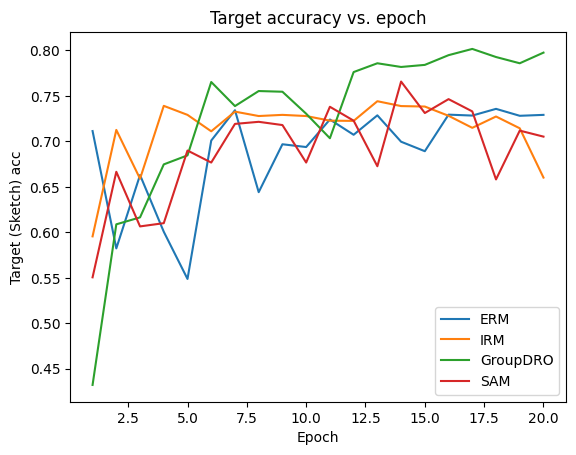

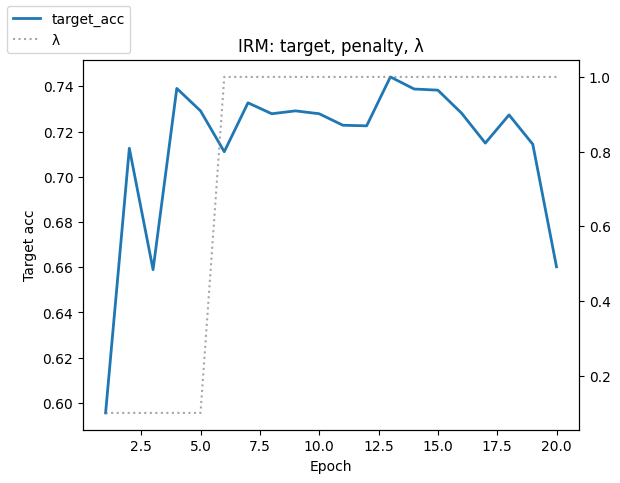

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
for name, p in paths.items():
    if os.path.exists(p):
        df = pd.read_csv(p)
        plt.plot(df["epoch"], df["target_acc"], label=name)
plt.xlabel("Epoch"); plt.ylabel("Target (Sketch) acc"); plt.title("Target accuracy vs. epoch"); plt.legend(); plt.show()

# IRM: show penalty & lambda vs epoch
if os.path.exists(paths.get("IRM","")):
    df = pd.read_csv(paths["IRM"])
    if {"lambda","target_acc"}.issubset(df.columns):
        fig, ax1 = plt.subplots()
        ax1.plot(df["epoch"], df["target_acc"], label="target_acc", lw=2)
        ax1.set_xlabel("Epoch"); ax1.set_ylabel("Target acc")
        if "penalty" in df.columns:
            ax2 = ax1.twinx()
            ax2.plot(df["epoch"], df["penalty"], '--', label="IRM penalty", alpha=0.7)
            ax2.set_ylabel("IRM penalty")
        if "lambda" in df.columns:
            ax2 = ax1.twinx()
            ax2.plot(df["epoch"], df["lambda"], ':', label="λ", alpha=0.7, color='gray')
        fig.legend(loc="upper left"); plt.title("IRM: target, penalty, λ"); plt.show()

# GroupDRO: plot q (domain weights) vs epoch
import numpy as np
if os.path.exists(paths.get("GroupDRO","")):
    df = pd.read_csv(paths["GroupDRO"])
    # support multiple possible column names for q logs
    q_cols = [c for c in df.columns if c.startswith("q_")] or [c for c in df.columns if c in ["q0","q1","q2"]]
    if q_cols:
        q = df[q_cols].values
        plt.figure()
        for i,c in enumerate(q_cols):
            plt.plot(df["epoch"], q[:,i], label=c)
        plt.xlabel("Epoch"); plt.ylabel("q (domain weight)"); plt.title("GroupDRO: q evolution"); plt.legend(); plt.show()


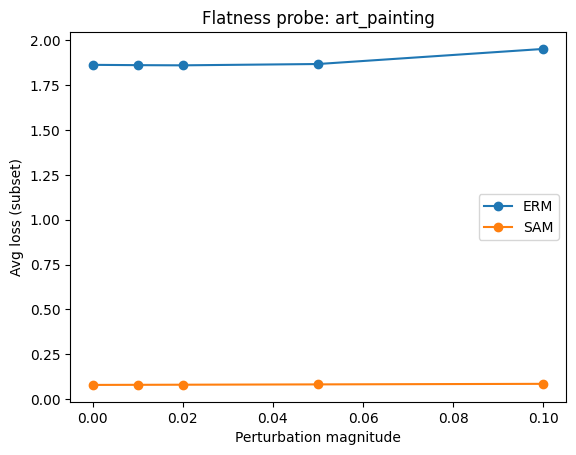

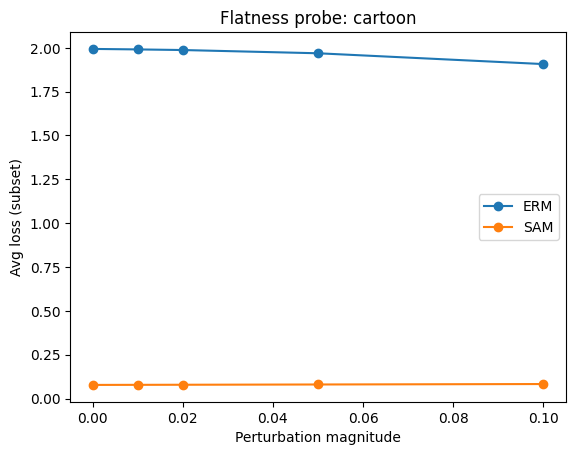

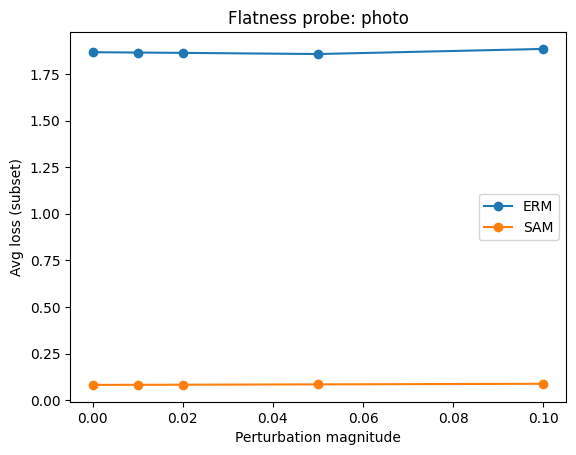

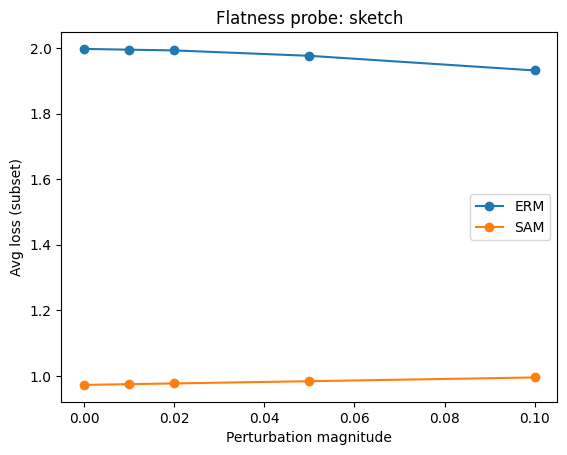

In [15]:
import torch, numpy as np
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 7 # Assuming 7 classes based on previous outputs

@torch.no_grad()
def _subset(loader, max_batches=3):
    out=[];
    for i,(x,y) in enumerate(loader):
        out.append((x,y))
        if i+1>=max_batches: break
    return out

def set_bn_eval(m):
    # Freeze BN running stats (affine params still train). Helps SAM stability.
    if isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
        m.eval()

def build_resnet50_sam(num_classes: int, train_layers=("layer3","layer4","fc")):
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    for p in m.parameters(): p.requires_grad = False
    if "layer3" in train_layers:
        for p in m.layer3.parameters(): p.requires_grad = True
    if "layer4" in train_layers:
        for p in m.layer4.parameters(): p.requires_grad = True
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def build_resnet50(num_classes: int):
    # pretrained ResNet-50, replace final layer
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def flatness_probe_per_domain(model, eval_loaders, device, rhos=(0.0, 0.01, 0.02, 0.05, 0.1)):
    ce = nn.CrossEntropyLoss()
    model.eval()
    params = [p for p in model.parameters() if p.requires_grad and p.dim()>0]
    dirs = []
    for p in params:
        d = torch.randn_like(p)
        d = d / (d.norm(p=2) + 1e-12)
        dirs.append(d)
    # snapshot
    orig = [p.data.clone() for p in params]
    # pre-sample tiny subsets per domain
    subsets = {name: _subset(ld, 3) for name, ld in eval_loaders.items()}
    losses = {name: [] for name in subsets.keys()}

    for r in rhos:
        with torch.no_grad(): # Add no_grad() context here
            for p,d in zip(params, dirs): p.add_(d, alpha=r)
        for name, subset in subsets.items():
            total=n=0
            for xb,yb in subset:
                xb=xb.to(device); yb=yb.to(device)
                total += ce(model(xb), yb).item()* yb.size(0); n += yb.size(0)
            losses[name].append(total/max(n,1))
        with torch.no_grad(): # Add no_grad() context here
            for p,o in zip(params, orig): p.copy_(o)
    return np.array(rhos), losses

# Usage example (ERM vs SAM, per-domain curves):
# load your best checkpoints into `erm_model` and `sam_model` built the same way as training
erm_model = build_resnet50(num_classes).to(device)
erm_model.load_state_dict(torch.load("outputs_erm/best_model.pt", map_location=device), strict=False)
erm_model.eval(); erm_model.to(memory_format=torch.channels_last); erm_model.apply(set_bn_eval)
sam_model = build_resnet50_sam(num_classes).to(device)
# Handle the 'module.' prefix from SWA state_dict and load with strict=False
sam_state_dict = torch.load("outputs_sam_asam/best_model_swa.pt", map_location=device)
new_sam_state_dict = {}
for k, v in sam_state_dict.items():
    if k.startswith('module.'):
        new_sam_state_dict[k[7:]] = v
    else:
        new_sam_state_dict[k] = v

sam_model.load_state_dict(new_sam_state_dict, strict=False)
sam_model.eval(); sam_model.to(memory_format=torch.channels_last); sam_model.apply(set_bn_eval)


# eval_loaders is expected to be defined from a previous cell (e.g. by calling make_loaders)
rhos, losses_erm = flatness_probe_per_domain(erm_model, eval_loaders, device)
rhos, losses_sam = flatness_probe_per_domain(sam_model, eval_loaders, device)
# Plot:
for name in eval_loaders.keys():
    plt.figure(); plt.plot(rhos, losses_erm[name], 'o-', label='ERM')
    plt.plot(rhos, losses_sam[name], 'o-', label='SAM'); plt.title(f'Flatness probe: {name}')
    plt.xlabel('Perturbation magnitude'); plt.ylabel('Avg loss (subset)'); plt.legend(); plt.show()

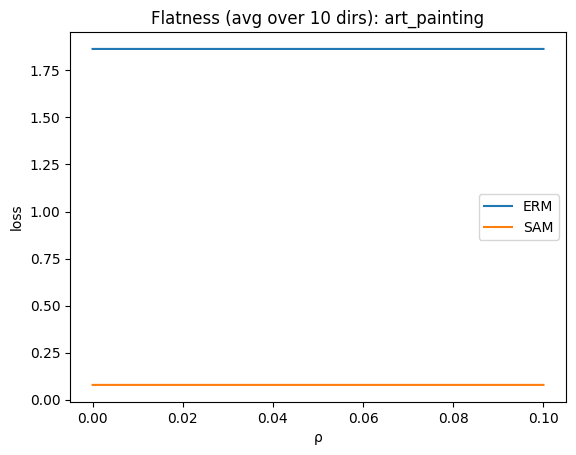

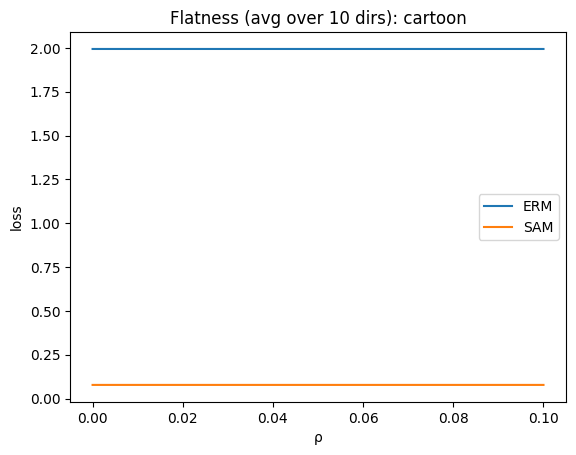

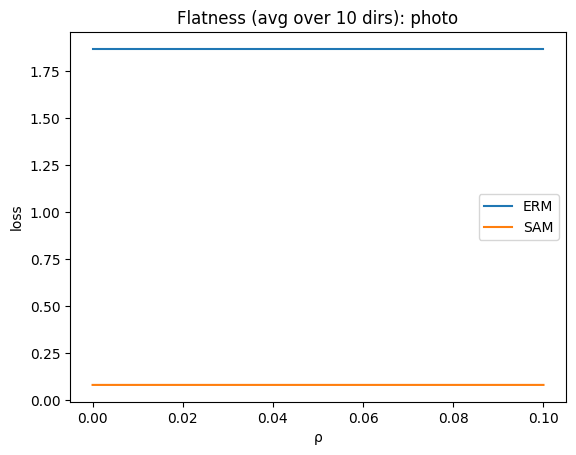

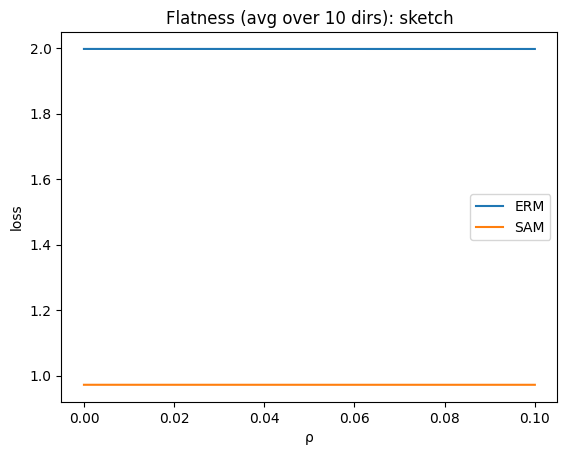

In [19]:
import numpy as np, torch, torch.nn as nn
import matplotlib.pyplot as plt

def _rand_dirs_like(params, adaptive=False, eps=1e-12):
    dirs=[]
    if adaptive:
        # ASAM-style relative scaling
        norms=[]
        tmp=[]
        for p in params:
            if not p.requires_grad or p.dim()==0: tmp.append(torch.zeros_like(p)); continue
            d = torch.randn_like(p); tmp.append(d)
            norms.append(((d*(p.abs()+eps))**2).sum())
        denom = torch.sqrt(torch.stack(norms).sum() + eps)
        for p,d in zip(params,tmp):
            if d.numel()==0: dirs.append(d); continue
            dirs.append(d * (p.abs()+eps) / denom)
    else:
        # plain L2-normalized
        denom = torch.sqrt(sum((torch.randn_like(p)**2).sum() for p in params if p.requires_grad and p.dim()>0))
        for p in params:
            dirs.append(torch.randn_like(p) / (denom + 1e-12) if p.requires_grad and p.dim()>0 else torch.zeros_like(p))
    return dirs

@torch.no_grad()
def flatness_probe_avg(model, eval_loaders, device, rhos=(0,0.01,0.02,0.05,0.1), K=10, adaptive=False, max_batches=3):
    ce = nn.CrossEntropyLoss(); model.eval()
    params = [p for p in model.parameters() if p.requires_grad and p.dim()>0]
    orig = [p.data.clone() for p in params]
    subsets = {n: [(x.to(device),y.to(device)) for x,y in _subset(ld,max_batches)] for n,ld in eval_loaders.items()}
    means = {n: np.zeros(len(rhos)) for n in subsets}
    stds  = {n: np.zeros(len(rhos)) for n in subsets}

    for k in range(K):
        dirs = _rand_dirs_like(params, adaptive=adaptive)
        vals = {n: [] for n in subsets}
        for ri,r in enumerate(rhos):
            for p,d in zip(params, dirs): p.add_(d, alpha=r)
            for n,subset in subsets.items():
                tot=ncount=0
                for xb,yb in subset:
                    tot += ce(model(xb), yb).item()* yb.size(0); ncount += yb.size(0)
                vals[n].append(tot/max(ncount,1))
            for p,o in zip(params, orig): p.copy_(o)
        for n in subsets:
            means[n] += np.array(vals[n]); stds[n] += np.array(vals[n])**2

    for n in subsets:
        means[n] /= K
        stds[n] = np.sqrt(np.maximum(stds[n]/K - means[n]**2, 0))

    return np.array(rhos), means, stds

# Example usage (snapshot SAM, not SWA):
K = 10 # Define K here
rhos, m_erm, s_erm = flatness_probe_avg(erm_model, eval_loaders, device, K=K, adaptive=False)
rhos, m_sam, s_sam = flatness_probe_avg(sam_model, eval_loaders, device, K=K, adaptive=True)
for name in eval_loaders.keys():
    plt.figure()
    plt.plot(rhos, m_erm[name], label="ERM"); plt.fill_between(rhos, m_erm[name]-s_erm[name], m_erm[name]+s_erm[name], alpha=0.2)
    plt.plot(rhos, m_sam[name], label="SAM"); plt.fill_between(rhos, m_sam[name]-s_sam[name], m_sam[name]+s_sam[name], alpha=0.2)
    plt.title(f"Flatness (avg over {K} dirs): {name}"); plt.xlabel("ρ"); plt.ylabel("loss"); plt.legend(); plt.show()